In [156]:
import logging
L = logging.getLogger(__name__)
from pathlib import Path
import pickle

import h5py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch.nn.functional import pad
from tqdm.auto import tqdm

In [157]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append(str(Path(".").resolve().parent.parent))

from berp.datasets import BerpDataset, NestedBerpDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [158]:
story_name = "old-man-and-the-sea"
subject = 15
run = 1

aligned_words = "word.csv"
aligned_phonemes = "phoneme.csv"
# aligned_words = f"../../workflow/heilbron2022/data/aligned/distilgpt2/{story_name}/word.csv"
# aligned_phonemes = f"../../workflow/heilbron2022/data/aligned/distilgpt2/{story_name}/phoneme.csv"

stimulus = "old-man-and-the-sea/run1.pkl"
# stimulus = f"../../workflow/heilbron2022/data/stimulus/distilgpt2/n1000/{story_name}/run{run}.pkl"

run_Xy = f"../../workflow/heilbron2022/data/run_Xy/{story_name}/sub{subject}/run{run}.h5"
# run_Xy = "/home/jgauthie/om2/others/heilbron2022/notebooks/exported/Xy/words_proba/sub1/run2.h5"

# This argument controls the meaning of the output `word_onsets` property. Non-default values may result
# in filtering of the dataset (words and constituent phonemes) in order to render the analysis interpretable.
# By default word onset obviously means word onset: the onset of the first phoneme in the acoustic stimulus.
#
# NOTE that this does not affect any time series onset features -- only the features accessed at the Berp
# representational level (the `word_onsets` property of a `BerpDataset`).
#
# Other options:
# - `"second_syllable"`: words have onset at their second syllable. This enables a control analysis to evaluate
#   how meaningful "word onset" is in itself, versus any meaningful point within a word. The dataset will be
#   filtered such that only multisyllabic words are present. TODO what happens to phonemes prior to second syllable onset?
word_onset_event = "second-syllable"

target_sample_rate = 128
output_path = f"{story_name}.sub{subject}.run{run}.pkl"

In [159]:
if word_onset_event not in ["word", "second-syllable"]:
    raise ValueError(f"unknown value for `word_onset_event`: {word_onset_event}")

## Load and process natural language stimulus

In [160]:
with Path(stimulus).open("rb") as f:
    story_stim = pickle.load(f)
    
assert story_stim.name == f"{story_name}/run{run}"

In [161]:
# Variable onset features are simply a variable onset intercept,
# word features and word surprisals.
X_variable = torch.concat(
    [torch.ones_like(story_stim.word_surprisals).unsqueeze(1),
     story_stim.word_features,
     story_stim.word_surprisals.unsqueeze(1)],
    dim=1)
variable_feature_names = ["recognition_onset"] + story_stim.word_feature_names + ["word_surprisal"]

assert X_variable.shape[1] == len(variable_feature_names)

In [162]:
variable_feature_names

['recognition_onset', 'word_frequency', 'word_surprisal']

## Load aligned word/phoneme presentation data

In [163]:
word_aligned_df = pd.read_csv(aligned_words, index_col=[0, 1]).loc[run].reset_index()
phoneme_aligned_df = pd.read_csv(aligned_phonemes, index_col=[0, 1]).loc[run].reset_index()
word_aligned_df

,word_idx,word,onset,offset,token_idx
0,0,HE,0.76,0.88,0
1,1,WAS,0.88,1.04,1
2,2,AN,1.04,1.12,2
3,3,OLD,1.12,1.41,3
4,4,MAN,1.41,1.79,4
...,...,...,...,...,...
608,572,INTO,175.78,175.98,682
609,573,STRIPS,175.98,176.37,683
610,574,FOR,176.37,176.48,684
611,575,SALTING,176.48,177.01,685


### Check for words missing in stimulus

{0, 419}

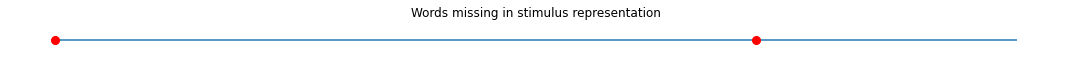

In [164]:
# Not all words in the presentation will be retained in the stimulus: words which
# ended up at the start of an input time series to the model were dropped, because
# the model didn't have those values as targets.
#
# By the above logic, the missing words will likely be distributed roughly evenly
# throughout the stimulus.
words_missing_in_stimulus = set(word_aligned_df.word_idx) - set(story_stim.word_ids.numpy())

plt.figure(figsize=(15, 1))
plt.hlines(0, 0, story_stim.word_ids.max())
plt.plot(list(words_missing_in_stimulus), np.zeros(len(words_missing_in_stimulus)), 'ro', ms=8, mfc='r')
plt.axis('off')
plt.title("Words missing in stimulus representation")
plt.tight_layout()

words_missing_in_stimulus

In [165]:
assert 0 == len(set(story_stim.word_ids.numpy()) - set(word_aligned_df.word_idx)), \
    "Stim words are present which are missing from the aligned data!"

### Check for phonemes missing in stimulus

We're guiding the check by `story_stim.word_ids`, so we won't run into any of the missing words we already uncovered in `word_ids` above.

In [166]:
# Phoneme annotations according to aligned df
aligned_phoneme_lookup = phoneme_aligned_df.groupby("word_idx").phoneme.apply(tuple).to_dict()

for i, word_id in enumerate(story_stim.word_ids.numpy()):
    stim_phons = story_stim.get_candidate_strs(i, 1)[0]
    aligned_phons = aligned_phoneme_lookup[word_id]

    assert aligned_phons == stim_phons, \
        f"{word_id}: {aligned_phons} != {stim_phons}"

## Load design matrix data

In [167]:
with h5py.File(run_Xy) as f:
    assert subject == f.attrs["subject"]
    assert run == f.attrs["run"]
    
    X = f["X"][()]
    y = f["y"][()].T
    
    sensor_names = f.attrs["ch_names"].tolist()
    ts_feature_names = f.attrs["feature_names"].tolist()
    sfreq = f.attrs["sfreq"]

In [168]:
assert X.shape[0] == y.shape[0]
assert X.shape[1] == len(ts_feature_names)
assert y.shape[1] == len(sensor_names)

### Add intercept feature to time series

In [169]:
X = np.hstack([np.ones((X.shape[0], 1)), X])
ts_feature_names = ['intercept'] + ts_feature_names

### Remove surprisal+frequency data

In [170]:
drop_ts_features = ["all_words_lexical_surprise", "all_words_unigram_surprise"]
keep_ts_feature_idxs = [i for i, name in enumerate(ts_feature_names) if name not in drop_ts_features]

X = X[:, keep_ts_feature_idxs]
ts_feature_names = [name for i, name in enumerate(ts_feature_names) if i in keep_ts_feature_idxs]
ts_feature_names

['intercept',
 'all_words_onset',
 'all_phons_onset',
 'all_phons_pitch',
 'all_phons_env_var',
 'all_phons_surprisals',
 'all_phons_sg1',
 'all_phons_sg2',
 'all_phons_sg3',
 'all_phons_sg4',
 'all_phons_sg5',
 'all_phons_sg6',
 'all_phons_sg7',
 'all_phons_sg8']

## Check agreement of onset features with alignment

### Word onset

Verify that the word onsets as represented in the design matrix agree with the word onset data as given in the aligned annotation.

In [171]:
word_onset_idx = ts_feature_names.index("all_words_onset")
X_onset_times = X[:, word_onset_idx].nonzero()[0] / sfreq
X_onset_times[:10]

array([0.7578125, 0.8828125, 1.0390625, 1.1171875, 1.40625  , 1.8671875,
       2.078125 , 2.40625  , 2.7734375, 2.8828125])

In [172]:
aligned_onset_times = word_aligned_df.groupby("word_idx").onset.min()
aligned_onset_times.values[:10]

array([0.76, 0.88, 1.04, 1.12, 1.41, 1.87, 2.08, 2.41, 2.77, 2.88])

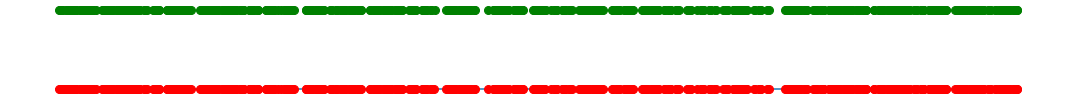

In [173]:
plt.figure(figsize=(15, 1.5))
plt.hlines(0, 0, X_onset_times.max())
plt.plot(X_onset_times, np.zeros(len(X_onset_times)), 'ro', ms=8, mfc='r')
plt.plot(aligned_onset_times, np.ones(len(aligned_onset_times)), 'go', ms=8)
plt.axis('off')
plt.tight_layout()

In [174]:
# Words that appear in the Heilbron annotation but don't make any sense,
# and which we want to ignore.
FORSAKEN_WORDS = [
    # run_idx, word_onset, first_phoneme_onset, num_phonemes
    (3, 22.77, 22.77, 4),  # "boat" transcribed phonemically as /buks/
    (16, 102.51, 102.52, 7),  # "dubbing" transcribed as /dklʌbɪŋ/
]

In [175]:
# NB aligned annotation only has precision to 2 places, so we'll have to round.
X_onset_times_corrected = X_onset_times.round(2)
drop_times = np.array([time for exc_run, time, _, _ in FORSAKEN_WORDS if exc_run == run])
X_onset_times_corrected = X_onset_times_corrected[~np.in1d(X_onset_times_corrected, drop_times)]

In [176]:
# len(X_onset_times_corrected), len(aligned_onset_times)

In [177]:
# set(X_onset_times_corrected) - set(aligned_onset_times)

In [178]:
assert len(X_onset_times_corrected) == len(aligned_onset_times)

In [179]:
np.testing.assert_allclose(X_onset_times_corrected, aligned_onset_times, atol=1e-1)

In [180]:
# # Find overlap
# array1 = X_onset_times
# array2 = word_aligned_df.onset.unique()
# import itertools
# from tqdm.auto import trange
# matches = []
# no_match = []
# for i0 in trange(array1.shape[0]):
#     for i1 in range(array2.shape[0]):
#         if np.isclose(array1[i0], array2[i1], atol=1e-1):
#             matches.append((i0, i1))
#             break
#     else:
#         no_match.append(i0)

In [181]:
# len(no_match)

In [182]:
# len(matches)

In [183]:
# plt.figure(figsize=(15, 2))
# plt.hlines(0, 0, X_onset_times.max())
# mask = np.zeros(len(X_onset_times), dtype=bool)
# mask[no_match] = True
# plt.plot(X_onset_times[mask], np.zeros(mask.sum()), 'ro', ms=8, mfc='r', alpha=0.3)
# plt.plot(X_onset_times[~mask], np.zeros((~mask).sum()), 'ro', ms=8, mfc='g', alpha=0.3)
# # plt.plot(word_aligned_df.onset.values, np.ones(len(word_aligned_df)), 'go', ms=8)
# plt.axis('off')
# plt.tight_layout()

### Phoneme onset

We'll do the same thing now for phoneme onsets, making sure there are no discrepancies between our understanding of phoneme onset and the assumptions going into the design matrix production.

In [184]:
phon_onset_idx = ts_feature_names.index("all_phons_onset")
X_phon_onset_times = X[:, phon_onset_idx].nonzero()[0] / sfreq
X_phon_onset_times[:10]

array([0.765625 , 0.8125   , 0.8828125, 0.9609375, 0.9921875, 1.0390625,
       1.09375  , 1.125    , 1.1796875, 1.3046875])

In [185]:
aligned_phon_onset_times = phoneme_aligned_df.onset
aligned_phon_onset_times.values[:10]

array([0.77, 0.81, 0.88, 0.96, 0.99, 1.04, 1.09, 1.12, 1.18, 1.3 ])

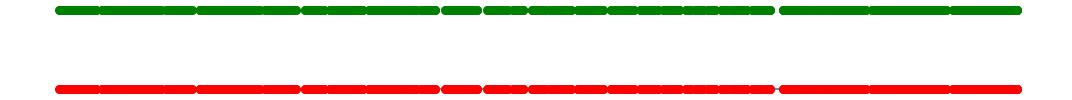

In [186]:
plt.figure(figsize=(15, 1.5))
plt.hlines(0, 0, X_phon_onset_times.max())
plt.plot(X_phon_onset_times, np.zeros(len(X_phon_onset_times)), 'ro', ms=8, mfc='r')
plt.plot(aligned_phon_onset_times, np.ones(len(aligned_phon_onset_times)), 'go', ms=8)
plt.axis('off')
plt.tight_layout()

In [187]:
X_phon_onset_times_corrected = X_phon_onset_times.round(2)
# Drop onset times for phonemes from `FORSAKEN_WORDS`
for exc_run, _, first_phon_onset_time, num_phonemes in FORSAKEN_WORDS:
    if exc_run == run:
        drop_start_idx = np.where(X_phon_onset_times_corrected == first_phon_onset_time)[0][0]
        X_phon_onset_times_corrected = np.concatenate([X_phon_onset_times_corrected[:drop_start_idx],
                                                       X_phon_onset_times_corrected[drop_start_idx + num_phonemes:]])
X_onset_times_corrected = X_onset_times_corrected[~np.in1d(X_onset_times_corrected, drop_times)]

In [188]:
# len(X_phon_onset_times_corrected), len(aligned_phon_onset_times)

In [189]:
# set(X_phon_onset_times_corrected) - set(aligned_phon_onset_times)

In [190]:
np.testing.assert_allclose(X_phon_onset_times_corrected, aligned_phon_onset_times, atol=1e-2, rtol=1e-2)

## Load signal data

In [191]:
min_time, max_time = 0, len(X) / sfreq
max_time

178.5625

In [192]:
# Check compatibility with alignment data.
assert min_time <= word_aligned_df.onset.min()
assert min_time <= phoneme_aligned_df.onset.min()
assert max_time >= word_aligned_df.offset.max()
assert max_time >= phoneme_aligned_df.offset.max()

## Replace onset features

Even though we already checked that the two annotations agree, we're going to insert our own aligned to the sample rate, just to make sure the setup is absolutely perfect.

In [193]:
word_aligned_df["onset"] = (word_aligned_df["onset"] * target_sample_rate).round() / target_sample_rate
word_aligned_df["offset"] = (word_aligned_df["offset"] * target_sample_rate).round() / target_sample_rate
phoneme_aligned_df["onset"] = (phoneme_aligned_df["onset"] * target_sample_rate).round() / target_sample_rate
phoneme_aligned_df["offset"] = (phoneme_aligned_df["offset"] * target_sample_rate).round() / target_sample_rate
phoneme_aligned_df["offset_word"] = (phoneme_aligned_df["offset_word"] * target_sample_rate).round() / target_sample_rate

In [194]:
word_onset_samples = (word_aligned_df["onset"] * target_sample_rate).astype(int)
phoneme_onset_samples = (phoneme_aligned_df["onset"] * target_sample_rate).astype(int)

# Drop words+phonemes which extend past the end of the time series.
word_onset_samples = word_onset_samples[word_onset_samples < len(X)]
phoneme_onset_samples = phoneme_onset_samples[phoneme_onset_samples < len(X)]

word_onset_features = np.zeros((len(X), 1))
phoneme_onset_features = np.zeros((len(X), 1))
word_onset_features[word_onset_samples] = 1
phoneme_onset_features[phoneme_onset_samples] = 1

X = np.concatenate((X, word_onset_features, phoneme_onset_features), axis=1)
ts_feature_names += ["word_onset", "phoneme_onset"]
assert X.shape[1] == len(ts_feature_names)

In [195]:
# Remove Heilbron onset data.
remove_onset_features = ["all_words_onset", "c_words_onset", "all_phons_onset"]
for feat in remove_onset_features:
    try:
        feat_idx = ts_feature_names.index(feat)
    except ValueError:
        L.warning(f"No feature {feat}")
    else:
        X = np.delete(X, feat_idx, axis=1)
        ts_feature_names = ts_feature_names[:feat_idx] + ts_feature_names[feat_idx + 1:]
        
assert X.shape[1] == len(ts_feature_names)

No feature c_words_onset


## Add phoneme-level features to time series

In [196]:
phoneme_ts = torch.zeros((X.shape[0], len(story_stim.phoneme_feature_names)))

phoneme_lookup_df = phoneme_aligned_df.set_index("word_idx")
for word_idx, phoneme_features in zip(story_stim.word_ids, story_stim.phoneme_features):
    onsets = np.array(list(phoneme_lookup_df.loc[[word_idx.item()], "onset"]))
    onset_samps = torch.tensor(onsets * target_sample_rate).long()
    phoneme_ts[onset_samps, :] = phoneme_features.to(phoneme_ts)

In [197]:
X = torch.cat([torch.tensor(X), phoneme_ts], axis=1)
ts_feature_names += story_stim.phoneme_feature_names

### Dev: check surprisal matches

In [198]:
# ts_feature_names

['intercept',
 'all_phons_pitch',
 'all_phons_env_var',
 'all_phons_surprisals',
 'all_phons_sg1',
 'all_phons_sg2',
 'all_phons_sg3',
 'all_phons_sg4',
 'all_phons_sg5',
 'all_phons_sg6',
 'all_phons_sg7',
 'all_phons_sg8',
 'word_onset',
 'phoneme_onset',
 'syllable_onset',
 'phoneme_surprisal',
 'phoneme_entropy',
 'syllable_surprisal']

PearsonRResult(statistic=0.5029710773579473, pvalue=7.583216026873215e-84)

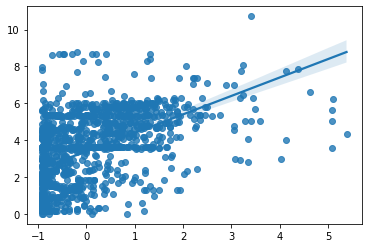

In [199]:
# import seaborn as sns
# # LOL there's some mismatch with the phons_surprisals in the ts -- this mean is not zero. it's okay..
# X[phoneme_onset_samples, ts_feature_names.index("all_phons_surprisals")].mean()

# heilb_surps = X[phoneme_onset_samples, ts_feature_names.index("all_phons_surprisals")].numpy()
# our_phon_surps = X[phoneme_onset_samples, ts_feature_names.index("phoneme_surprisal")].numpy()
# mask = heilb_surps != 0
# heilb_surps = heilb_surps[mask]
# our_phon_surps = our_phon_surps[mask]
# import scipy.stats as st

# sns.regplot(x=heilb_surps, y=our_phon_surps)
# st.pearsonr(heilb_surps, our_phon_surps)

## Produce BerpDataset representations

In [200]:
# Compute phoneme onsets relative to word onset.
phoneme_onsets = phoneme_aligned_df.groupby("word_idx") \
    .apply(lambda xs: list(xs.onset - xs.onset.min())).to_dict()
phoneme_onsets = [torch.tensor(phoneme_onsets.get(word_id.item(), [np.nan]))
                  for word_id in story_stim.word_ids]

In [201]:
word_offsets = word_aligned_df.groupby("word_idx").offset.max().to_dict()
word_offsets = torch.tensor([word_offsets.get(word_id.item(), np.nan)
                             for word_id in story_stim.word_ids])

In [202]:
keep_words = torch.arange(len(story_stim.word_ids))

# Produce onset information from canonical aligned data.
word_onsets = word_aligned_df.groupby("word_idx").onset.min().to_dict()
word_onsets = torch.tensor([word_onsets.get(word_id.item(), np.nan)
                            for word_id in story_stim.word_ids])

if word_onset_event == "second-syllable":
    keep_words, second_syllable_onsets = [], []
    for idx, (syllable_onsets_i, phoneme_onsets_i) in enumerate(zip(story_stim.word_events["syllable_onset"], phoneme_onsets)):
        if len(syllable_onsets_i) < 2:
            continue
        
        keep_words.append(idx)
        second_syllable_onsets.append(phoneme_onsets_i[syllable_onsets_i[1]])

    keep_words = torch.tensor(keep_words)
    
    word_onsets = word_onsets[keep_words] + torch.tensor(second_syllable_onsets)
    # Filter everything else, too.
    phoneme_onsets = [phoneme_onsets[i] - second_syllable_time for i, second_syllable_time in zip(keep_words, second_syllable_onsets)]
    word_offsets = word_offsets[keep_words]
    X_variable = X_variable[keep_words]
elif word_onset_event == "word":
    pass
else:
    raise ValueError()

In [203]:
max_num_phonemes = max(len(onsets) for onsets in phoneme_onsets)

# Sanity check: max_num_phonemes as computed from aligned data should
# match that produced earlier by the natural language stimulus processor
assert max_num_phonemes == story_stim.max_n_phonemes, \
    "%d %d" % (max_num_phonemes, story_stim.max_n_phonemes)

In [204]:
# Pad phoneme onset information
phoneme_onsets = torch.stack([
    pad(onsets, (0, max_num_phonemes - len(onsets)), value=0.)
    if len(onsets) < max_num_phonemes
    else onsets
    for onsets in phoneme_onsets
])

In [205]:
dataset = BerpDataset(
    name=f"{story_name}/sub{subject}/run{run}",
    stimulus_name=story_stim.name,
    sample_rate=int(sfreq),
    
    phonemes=story_stim.phonemes,
    
    retain_stim_word_ids=keep_words,
    word_onsets=word_onsets,
    word_offsets=word_offsets,
    phoneme_onsets=phoneme_onsets,
    
    X_ts=X,
    ts_feature_names=ts_feature_names,
    
    X_variable=X_variable,
    variable_feature_names=variable_feature_names,
    
    Y=y,
    sensor_names=sensor_names,
)

In [206]:
with Path(output_path).open("wb") as f:
    pickle.dump(dataset, f)